# Analysis of multi-omics data of chronic lymphocytic leukemia patients

In [1]:
%load_ext autoreload
%autoreload 2

This notebook shows a reanalyis using spfa of multi-omics data of chronic lymphocytic leukemia patients. The data and original analysis was published in:    
Lu, J., Cannizzaro, E., Meier-Abt, F., Scheinost, S., Bruch, P.M., Giles, H.A., Lütge, A., Hüllein, J., Wagner, L., Giacopelli, B. and Nadeu, F., 2021. Multi-omics reveals clinically relevant proliferative drive associated with mTOR-MYC-OXPHOS activity in chronic lymphocytic leukemia. Nature cancer, 2(8), pp.853-864.

In [2]:

import spfa

import torch
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib
#from lifelines import CoxPHFitter
from muon import MuData
import anndata as ad

rna = pd.read_csv("data/cll_data/rna_data.csv", index_col=0)
meth = pd.read_csv("data/cll_data/meth_data.csv", index_col=0)
drug = pd.read_csv("data/cll_data/drug_data.csv", index_col=0)
mutation = pd.read_csv("data/cll_data/mutation_data.csv", index_col=0)
cllpd =  pd.read_csv("data/cll_data/cllpd.csv", index_col=0)
survival = pd.read_csv("data/cll_data/survival_data.csv", index_col=0)
demographic = pd.read_csv("data/cll_data/demographic_data.csv", index_col=0)
doubling_time = pd.read_csv("data/cll_data/doublingTime_data.csv", index_col=0)


inter = np.intersect1d(np.intersect1d(np.intersect1d(rna.index, meth.index),drug.index),demographic.index)

scaler = StandardScaler()
rna = pd.DataFrame(scaler.fit_transform(rna), columns = rna.columns, index = rna.index)
meth = pd.DataFrame(scaler.fit_transform(meth), columns = meth.columns, index = meth.index)
drug = pd.DataFrame(scaler.fit_transform(drug), columns = drug.columns, index = drug.index)

llh = ["gaussian", "gaussian", "gaussian"]
views = ["mrna", "methylation", "drug"]

/home/tuemay/anaconda3/envs/spyder-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-10 11:13:34.465141: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 11:13:34.717448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-10 11:13:34.717495: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# get all observation ids that are in all datasets
all_obs = np.unique(np.concatenate((rna.index, meth.index, drug.index)))[np.unique(np.concatenate((rna.index, meth.index, drug.index)), return_counts=True)[1] >=2]
len(all_obs)

217

In [6]:
# align observations in all datasets and introduces nan for missing values
def align_df(df, idx):
    out = pd.DataFrame(np.nan, columns = df.columns, index=idx)
    idx = np.intersect1d(idx,df.index.tolist())
    df = df.loc[idx]
    out.loc[df.index,:] = df
    return out

rna = align_df(rna, all_obs)
drug = align_df(drug, all_obs)
meth = align_df(meth, all_obs)
survival = align_df(survival, all_obs)
mutation = align_df(mutation, all_obs)
demographic = align_df(demographic, all_obs)
doubling_time = align_df(doubling_time, all_obs)

# each view stored in data list
data = [rna, meth, drug]
# likelihood for each view
llh = ["gaussian", "gaussian", "gaussian"]

In [7]:
# generate input mudata object of omics views
adata = [spfa.tl.get_ad(data[i], llh[i]) for i in range(len(data))]
Xmdata = MuData({views[i]:adata[i] for i in range(len(adata))})
Xmdata

/home/tuemay/anaconda3/envs/spyder-env/lib/python3.10/site-packages/spfa/utils/utils.py:62: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(encoded_data)


MuData object with n_obs × n_vars = 217 × 10315
  3 modalities
    mrna:	217 x 5000
      uns:	'llh'
      obsm:	'mask'
    methylation:	217 x 5000
      uns:	'llh'
      obsm:	'mask'
    drug:	217 x 315
      uns:	'llh'
      obsm:	'mask'

In [26]:
# generate input mudata object of target covariates
age_ad = spfa.tl.get_ad(demographic[["age"]], llh = "gaussian")
sex_ad = spfa.tl.get_ad(demographic[["sex"]], llh = "bernoulli")
trisomy_ad = spfa.tl.get_ad(mutation[["trisomy12"]], llh = "bernoulli")
ighv_ad = spfa.tl.get_ad(mutation[["IGHV"]], llh = "bernoulli")

Ymdata = MuData({"trisomy12":trisomy_ad, "IGHV": ighv_ad, "Age": age_ad, "Sex": sex_ad})
Ymdata

/home/tuemay/anaconda3/envs/spyder-env/lib/python3.10/site-packages/spfa/utils/utils.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(encoded_data.reshape(-1,1))
/home/tuemay/anaconda3/envs/spyder-env/lib/python3.10/site-packages/spfa/utils/utils.py:53: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(encoded_data)
/home/tuemay/anaconda3/envs/spyder-env/lib/python3.10/site-packages/spfa/utils/utils.py:59: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype exp

MuData object with n_obs × n_vars = 217 × 4
  4 modalities
    trisomy12:	217 x 1
      uns:	'llh', 'label_map'
      obsm:	'mask'
    IGHV:	217 x 1
      uns:	'llh', 'label_map'
      obsm:	'mask'
    Age:	217 x 1
      uns:	'llh'
      obsm:	'mask'
    Sex:	217 x 1
      uns:	'llh', 'label_map'
      obsm:	'mask'

In [13]:
# collect sample metadata
metadata = np.hstack([trisomy_ad.X,ighv_ad.X, age_ad.X, sex_ad.X])
metadata = pd.DataFrame(metadata, columns=["trisomy12", "IGHV", "Age", "Sex"])

In [14]:
# generate design matrix with n_covariates x n_factors
n_factors = 7
design = torch.zeros((len(Ymdata.mod), n_factors))
design[0,0] = 1
design[1,1] = 1
design[2,2]=1
design[3,3]=1

design


tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]])

The design matrix specifies which factor should be guided by which covariates. In our case the first 4 factors are guided the 4 entries in Ymdata (IGHV, trisomy12, Age, Sex).

In [27]:
model = spfa.spFA(Xmdata=Xmdata,
            Ymdata = Ymdata,
            num_factors=7,
            design = design,
            device=torch.device('cpu'),
            ard = False,
            horseshoe = True,
            metadata= metadata,
            subsample=0,
            target_scale=[500 for  i in range(len(Ymdata.mod))])


This sets up the model, key parameters are:
* Xmdata: contains the omics modalities as MuData object
* Ymdata: contains the target covariates as MuData object
* num_factors: number of factors to fit
* device: device to use for fitting. We highly recommend to run spfa with a cuda device (torch.device("cuda"))
* ard: whether to use sparse automatic relevance determination priors on weights
* horseshoe: whether to use sparse horseshoe priors on weights
* subsample: whether to subsample the data during fitting. Recommended for very large data sets like single cell data sets.
* target_scale: crucial hyperparameter to scale how strong factors are guided by target covariates. Too high scaling parameters can lead to overfitting (Factors don't explain variance of Xmdata, but perfectly predict Ymdata). Too low values can lead to the model ignoring the covariate guidance.


Current Elbo 2.98E+06 | Delta: 8776: 100%|██████████| 3500/3500 [09:10<00:00,  6.36it/s]    


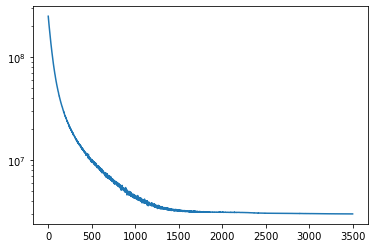

In [28]:
# fit and plot loss
model.fit(n_steps=3500, lr=0.01)
plt.semilogy(model.history)


<AxesSubplot:xlabel='Loadings', ylabel='Features'>

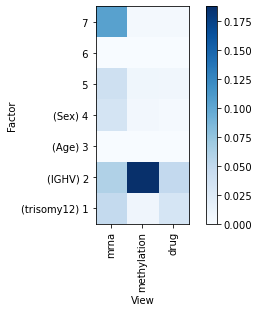

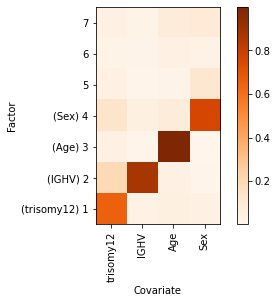

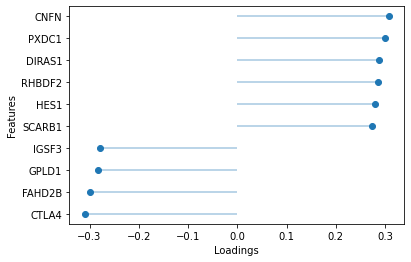

In [29]:
# plot fraction of variance explained of each view by each factor
spfa.pl.plot_variance_explained(model)

# plot factor covariate correlations
spfa.pl.plot_factor_covariate_cor(model, metavar=["trisomy12", "IGHV", "Age", "Sex"])

# plot top weights of factor 1 in view 1
spfa.pl.plot_top_weights(model, view=0, factor=0)

In [30]:
# to access weights and factors directly use attributes Z and W:
Z = model.Z
W = model.W
